<a href="https://colab.research.google.com/github/basselkassem/easy21/blob/master/monteControl_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Libs

In [1]:
!pip install import_ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=9682e9ee40579f6e1eb052f3b5bb368ab8f1027ca5a1c1cbebf1b40bc8f6eb7b
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [3]:
from google.colab import drive
drive.mount("/content/drive", )
%cd /content/drive/'My Drive'/'Colab Notebooks'/easy21

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/easy21


#Monte-Carlo Control in Easy21

- Initialise the value function to zero
- Use a time-varying scalar step-size of αt = 1/N(st,at) where N(s, a) is the number
of times that action a has been selected from state s
- Use e-greedy exploration strategy with et = N0/(N0 + N(st)), where N0 = 100 is a constant, N(s) is the number of times that state s has been visited
- Choose an alternative value for N0, if it helps producing better results. 
- Plot the optimal
value function V∗(s) = max_a[Q∗(s, a)] using axes for dealer and the player values

# Import Libs

In [0]:
import import_ipynb
import environment as env
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import plotly.graph_objects as go
from matplotlib import cm
import plotly.figure_factory as FF
from scipy.spatial import Delaunay

In [0]:
test_easy21 = env.Environment()
next_state, reward, done = test_easy21.init()

# class MonteCarloControl

In [0]:
class MonteCarloControl:

    def __init__(self, episodes_num, N0 = 100):
        self.episodes_num = episodes_num
        self.Nsa = defaultdict(int) #number of visiting state s from taking action a
        self.Q = defaultdict(int) # action-value function
        self.N0 = N0
        self.easy21 = env.Environment(mode = 'no_debug')

    # compute the number of visiting state s
    def get_Ns(self, state):
        return self.Nsa[state, 0] + self.Nsa[state, 1]

    def epsilon_greedy(self, state):
        epsilon = self.N0 / (self.N0 + self.get_Ns(state))
        if np.random.random() < epsilon:
            hit = self.Q[state, 0]
            stick = self.Q[state, 1]
            if hit > stick:
                return 0
            if hit == stick:
                return self.easy21.sample_action()
            if hit < stick:
                return 1
        else:
            return self.easy21.sample_action()

    def agent_policy(self, state):
        return self.epsilon_greedy(state)

    def policy_improvement(self, reward, episode):
        for state_action in episode:
            self.Nsa[state_action] += 1
            alpha = 1 / self.Nsa[state_action]
            self.Q[state_action] += alpha * (reward - self.Q[state_action])

    def policy_evaluation(self, state):
        done = False
        episode = []
        returned_reward = 0
        while not done:
            player_action = self.agent_policy(state)
            episode.append((state, player_action))
            state, reward, done = self.easy21.step(state, player_action)
            returned_reward += reward
        return returned_reward, episode

    def policy_iteration(self):
        for episode in np.arange(self.episodes_num):
            self.easy21 = env.Environment(mode = 'n_debug')
            state, _, done = self.easy21.init()
            reward, episode = self.policy_evaluation(state)
            self.policy_improvement(reward, episode)

# Util functions

In [0]:
def prepare_axises(Q):
    X, Y, Z = [], [], []
    for dealer in env.DEALER_FIRST_CARD_SPACE:
        for player in range(1, env.MAX_VALUE + 1):
            state = dealer, player
            X.append(dealer)
            Y.append(player)
            Z.append(max(Q[state, env.HIT], Q[state, env.STICK]))
    return X, Y, Z

def draw_surf(X, Y, Z, title):
    fig = plt.figure(figsize = (10, 8))
    ax = fig.gca(projection='3d')
    surf = ax.plot_trisurf(X, Y, Z, cmap=cm.coolwarm)
    ax.set_xlabel('dealer')
    ax.set_ylabel('player')
    ax.set_zlabel('Value')
    plt.title(title)
    plt.xticks(env.DEALER_FIRST_CARD_SPACE)
    plt.show()

def draw_deluanay_surf(X, Y, Z, title):
    u = np.linspace(0, 2*np.pi, env.MAX_VALUE)
    v = np.linspace(0, 2*np.pi, env.CARD_VALUE_MAX)
    u,v = np.meshgrid(u,v)
    u = u.flatten()
    v = v.flatten()

    points2D = np.vstack([u,v]).T
    tri = Delaunay(points2D)
    simplices = tri.simplices

    fig = FF.create_trisurf(z=Z, x = X, y = Y, simplices=simplices)

    scene = dict(
        xaxis = dict(nticks=10, range=[env.CARD_VALUE_MIN, env.CARD_VALUE_MAX], tick0 = 1),
        yaxis = dict(nticks=21, range=[env.MIN_VALUE, env.MAX_VALUE], ticks='outside', tick0 = 1),
        zaxis = dict(nticks=10, range=[np.min(Z) - 0.5, np.max(Z) + 0.5],),
        xaxis_title='Dealer',
        yaxis_title='Player',
        zaxis_title='Value',
    )
    fig.update_layout(scene = scene,
                    title = title,
                    autosize = True,
                    width=700, 
                    height=500,
                    margin = dict(l=65, r=50, b=65, t=90)
    )
    fig.show()

# Agent training
1.   N0 = 100
2.   Number of episodes = 100000



In [26]:
%%time
episodes_num = env.EPISODES_NUMS[3]
N0 = env.N0_VALUES[1]
agent = MonteCarloControl(episodes_num, N0 = N0 )
agent.policy_iteration()

CPU times: user 4.96 s, sys: 0 ns, total: 4.96 s
Wall time: 4.96 s


## Draw resullt

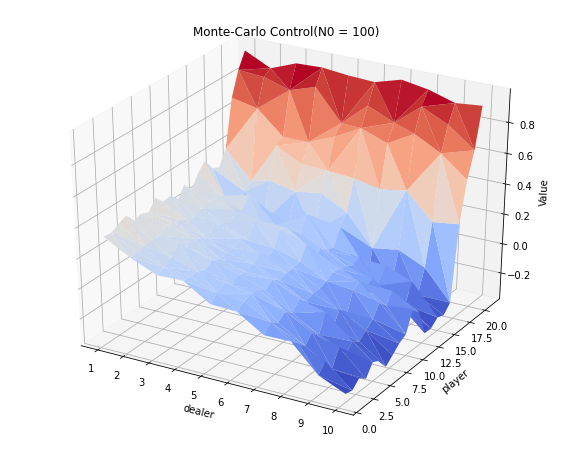

In [52]:
title = 'Monte-Carlo Control(N0 = 100)'
X, Y, Z = prepare_axises(agent.Q)
draw_surf(X, Y, Z, title)
draw_deluanay_surf(X, Y, Z, title)

# Agent training
1.   N0 = 50
2.   Number of episodes = 100000



In [53]:
%%time
episodes_num = env.EPISODES_NUMS[3]
N0 = env.N0_VALUES[0]
agent = MonteCarloControl(episodes_num, N0 = N0 )
agent.policy_iteration()

CPU times: user 5.23 s, sys: 0 ns, total: 5.23 s
Wall time: 5.24 s


## Draw resullt

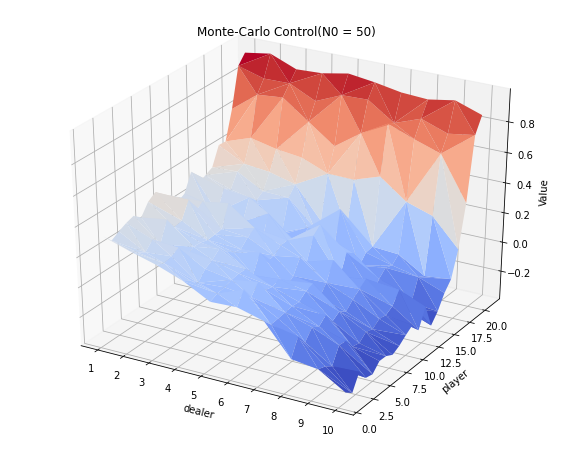

In [55]:
title = 'Monte-Carlo Control(N0 = 50)'
X, Y, Z = prepare_axises(agent.Q)
draw_surf(X, Y, Z, title)
draw_deluanay_surf(X, Y, Z, title)

# Agent training
1.   N0 = 1000
2.   Number of episodes = 100000



In [57]:
%%time
episodes_num = env.EPISODES_NUMS[3]
N0 = env.N0_VALUES[2]
agent = MonteCarloControl(episodes_num, N0 = N0 )
agent.policy_iteration()

CPU times: user 4.6 s, sys: 0 ns, total: 4.6 s
Wall time: 4.6 s


## Draw resullt

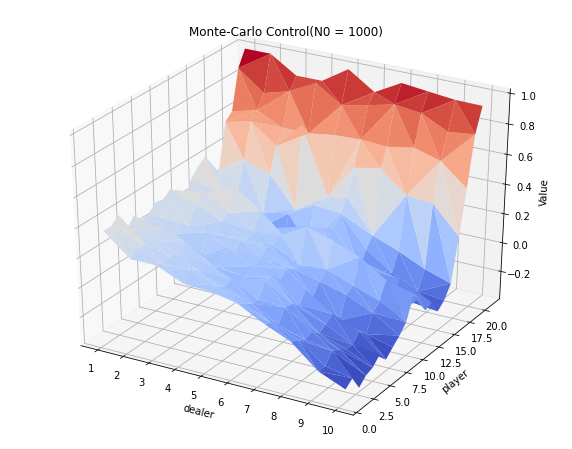

In [59]:
title = 'Monte-Carlo Control(N0 = 1000)'
X, Y, Z = prepare_axises(agent.Q)
draw_surf(X, Y, Z, title)
draw_deluanay_surf(X, Y, Z, title)